# Backtest Playground

`Run -> Run All Cells` だけで、データ取得・バックテスト・JSON保存・可視化まで実行します。

In [1]:
from pathlib import Path
import os
import sys

CANDIDATE_ROOTS = [
    Path.cwd(),
    Path.cwd().parent,
    Path('/Users/umegakigen/gitProjects/crypto_trade_bot'),
]

ROOT = None
for candidate in CANDIDATE_ROOTS:
    if (candidate / 'pybot').exists() and (candidate / 'research').exists():
        ROOT = candidate
        break

if ROOT is None:
    raise RuntimeError('project root not found')

os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print('ROOT =', ROOT)


ROOT = /Users/umegakigen/gitProjects/crypto_trade_bot


In [2]:
# Parameters
PAIR = 'SOL/USDC'
TIMEFRAME = '2h'  # '2h' or '4h'
YEARS_OF_DATA = 3
BARS_PER_DAY_BY_TIMEFRAME = {'2h': 12, '4h': 6}
if TIMEFRAME not in BARS_PER_DAY_BY_TIMEFRAME:
    raise ValueError(f'unsupported timeframe: {TIMEFRAME}')
LIMIT = YEARS_OF_DATA * 365 * BARS_PER_DAY_BY_TIMEFRAME[TIMEFRAME]
REFRESH_DATA = False

CONFIG_PATH = ROOT / 'research/models/core_long_v0/config/current.json'
CSV_PATH = ROOT / f'research/data/raw/solusdc_{TIMEFRAME}_live.csv'
OUTPUT_PATH = ROOT / 'research/data/processed/backtest_latest.json'

INITIAL_CAPITAL_JPY = 1_000_000

print('LIMIT =', LIMIT, f'(about {YEARS_OF_DATA} years)')
print('CONFIG_PATH =', CONFIG_PATH)
print('CSV_PATH =', CSV_PATH)
print('OUTPUT_PATH =', OUTPUT_PATH)
print('INITIAL_CAPITAL_JPY =', INITIAL_CAPITAL_JPY)

from datetime import UTC, datetime
RUN_LABEL = datetime.now(UTC).isoformat().replace('+00:00', 'Z')
print('RUN_LABEL =', RUN_LABEL)


LIMIT = 13140 (about 3 years)
CONFIG_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/models/core_long_v0/config/current.json
CSV_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_2h_live.csv
OUTPUT_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/processed/backtest_latest.json
INITIAL_CAPITAL_JPY = 1000000
RUN_LABEL = 2026-02-22T02:33:11.356693Z


In [3]:
import importlib.util
import os
import subprocess
from datetime import UTC, datetime

if importlib.util.find_spec('matplotlib') is None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib'])

import json
from collections import Counter

import matplotlib.pyplot as plt

from pybot.adapters.market_data.ohlcv_provider import OhlcvProvider
from research.src.adapters.csv_bar_repository import write_bars_to_csv, read_bars_from_csv


def run_backtest_fresh_process(config_path: Path, bars_path: Path, output_path: Path) -> dict:
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    before_mtime_ns = output_path.stat().st_mtime_ns if output_path.exists() else None
    if output_path.exists():
        output_path.unlink()

    cmd = [
        sys.executable,
        '-m',
        'research.scripts.run_backtest',
        '--config',
        str(config_path),
        '--bars',
        str(bars_path),
        '--output',
        str(output_path),
    ]

    env = os.environ.copy()
    prev_pythonpath = env.get('PYTHONPATH', '')
    env['PYTHONPATH'] = str(ROOT) if not prev_pythonpath else f"{str(ROOT)}{os.pathsep}{prev_pythonpath}"

    started_at = datetime.now(UTC)
    try:
        result = subprocess.run(
            cmd,
            cwd=str(ROOT),
            check=True,
            capture_output=True,
            text=True,
            env=env,
        )
    except subprocess.CalledProcessError as error:
        print('[backtest-run failed]')
        if error.stdout and error.stdout.strip():
            print('[stdout]')
            print(error.stdout.strip())
        if error.stderr and error.stderr.strip():
            print('[stderr]')
            print(error.stderr.strip())
        raise RuntimeError(
            f"backtest command failed: exit_code={error.returncode}, cmd={' '.join(error.cmd)}"
        ) from error
    finished_at = datetime.now(UTC)

    if not output_path.exists():
        raise RuntimeError(f'backtest output was not generated: {output_path}')

    after_mtime_ns = output_path.stat().st_mtime_ns
    print(
        '[backtest-run]',
        {
            'started_at_utc': started_at.isoformat().replace('+00:00', 'Z'),
            'finished_at_utc': finished_at.isoformat().replace('+00:00', 'Z'),
            'output_path': str(output_path),
            'output_mtime_ns': after_mtime_ns,
            'output_changed': before_mtime_ns != after_mtime_ns,
        },
    )

    if result.stdout.strip():
        print(result.stdout.strip())
    if result.stderr.strip():
        print(result.stderr.strip())

    with output_path.open('r', encoding='utf-8') as f:
        return json.load(f)


In [4]:
# CONFIG_SOURCE
print('[config] using model config:', CONFIG_PATH)


[config] using model config: /Users/umegakigen/gitProjects/crypto_trade_bot/research/models/core_long_v0/config/current.json


In [5]:
provider = OhlcvProvider()

def fetch_or_backfill(limit: int):
    if limit <= 1000:
        return provider.fetch_bars(pair=PAIR, timeframe=TIMEFRAME, limit=limit)
    return provider.fetch_bars_backfill(pair=PAIR, timeframe=TIMEFRAME, total_limit=limit)

if REFRESH_DATA or not CSV_PATH.exists():
    bars_fetched = fetch_or_backfill(LIMIT)
    write_bars_to_csv(CSV_PATH, bars_fetched)
    print(f'[fetched] {len(bars_fetched)} bars -> {CSV_PATH}')
else:
    bars_cached = read_bars_from_csv(CSV_PATH)
    if len(bars_cached) < LIMIT:
        print(f'[cache-insufficient] {len(bars_cached)} < {LIMIT}, refetching...')
        bars_fetched = fetch_or_backfill(LIMIT)
        write_bars_to_csv(CSV_PATH, bars_fetched)
        print(f'[fetched] {len(bars_fetched)} bars -> {CSV_PATH}')
    else:
        print(f'[cached] using existing file: {CSV_PATH} ({len(bars_cached)} bars)')


[cached] using existing file: /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_2h_live.csv (13140 bars)


In [6]:
report_json = run_backtest_fresh_process(CONFIG_PATH, CSV_PATH, OUTPUT_PATH)

print('[run]', RUN_LABEL)

print('[saved]', OUTPUT_PATH, 'mtime_ns=', OUTPUT_PATH.stat().st_mtime_ns)
report_json['summary']


[backtest-run] {'started_at_utc': '2026-02-22T02:33:11.797848Z', 'finished_at_utc': '2026-02-22T02:33:13.402123Z', 'output_path': '/Users/umegakigen/gitProjects/crypto_trade_bot/research/data/processed/backtest_latest.json', 'output_mtime_ns': 1771727593396210295, 'output_changed': True}
[research] backtest completed {'total_bars': 13140, 'decision_enter_count': 81, 'decision_no_signal_count': 11375, 'closed_trades': 80, 'open_trades': 1, 'wins': 27, 'losses': 53, 'win_rate_pct': 33.75, 'average_pnl_pct': 0.263408, 'total_pnl_pct': 21.072602, 'average_scaled_pnl_pct': 0.4281, 'total_scaled_pnl_pct': 34.247989, 'average_r_multiple': 0.105662, 'first_bar_close_time': '2021-11-24T16:00:00Z', 'last_bar_close_time': '2026-02-21T18:00:00Z'}
[research] top no-signal reasons [('EMA_TREND_FILTER_FAILED', 6236), ('ATR_STOP_CONFLICT_MAX_LOSS', 2249), ('RECLAIM_NOT_FOUND', 1437), ('CHASE_ENTRY_TOO_FAR_FROM_EMA', 1168), ('RSI_TOO_HIGH', 146)]
[research] report /Users/umegakigen/gitProjects/crypto_t

{'total_bars': 13140,
 'decision_enter_count': 81,
 'decision_no_signal_count': 11375,
 'closed_trades': 80,
 'open_trades': 1,
 'wins': 27,
 'losses': 53,
 'win_rate_pct': 33.75,
 'average_pnl_pct': 0.263408,
 'total_pnl_pct': 21.072602,
 'average_scaled_pnl_pct': 0.4281,
 'total_scaled_pnl_pct': 34.247989,
 'average_r_multiple': 0.105662,
 'first_bar_close_time': '2021-11-24T16:00:00Z',
 'last_bar_close_time': '2026-02-21T18:00:00Z'}

[tp_r_sweep] range {'start': 1.5, 'end': 3.0, 'step': 0.1}
{'r_multiple': 1.5, 'closed_trades': 94, 'win_rate_pct': 43.617, 'total_pnl_pct': 7.930349, 'total_scaled_pnl_pct': 18.758075, 'average_scaled_pnl_pct': 0.199554}
{'r_multiple': 1.6, 'closed_trades': 93, 'win_rate_pct': 41.9355, 'total_pnl_pct': 7.603743, 'total_scaled_pnl_pct': 14.992967, 'average_scaled_pnl_pct': 0.161215}
{'r_multiple': 1.7, 'closed_trades': 91, 'win_rate_pct': 39.5604, 'total_pnl_pct': 0.795331, 'total_scaled_pnl_pct': 9.961126, 'average_scaled_pnl_pct': 0.109463}
{'r_multiple': 1.8, 'closed_trades': 89, 'win_rate_pct': 38.2022, 'total_pnl_pct': 1.364844, 'total_scaled_pnl_pct': 6.591257, 'average_scaled_pnl_pct': 0.074059}
{'r_multiple': 1.9, 'closed_trades': 86, 'win_rate_pct': 38.3721, 'total_pnl_pct': 12.438231, 'total_scaled_pnl_pct': 18.693646, 'average_scaled_pnl_pct': 0.217368}
{'r_multiple': 2.0, 'closed_trades': 82, 'win_rate_pct': 37.8049, 'total_pnl_pct': 17.434492, 'total_scaled_pnl_pct': 24.63

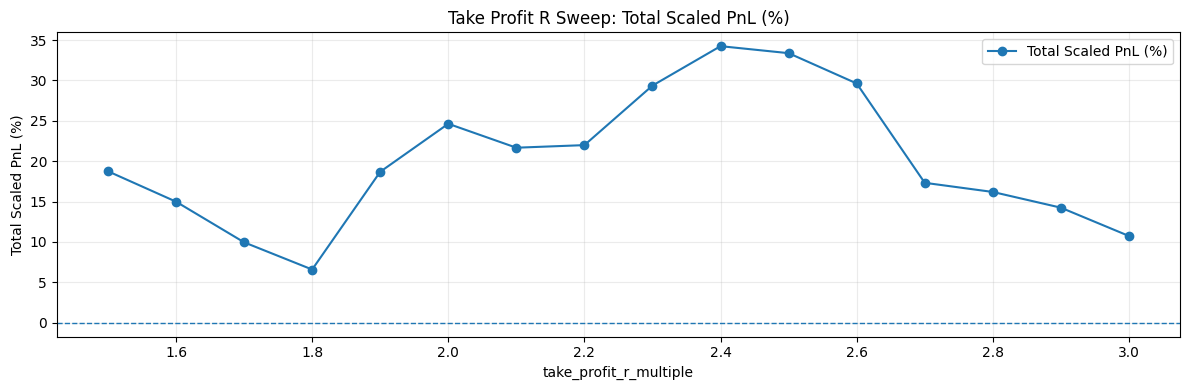

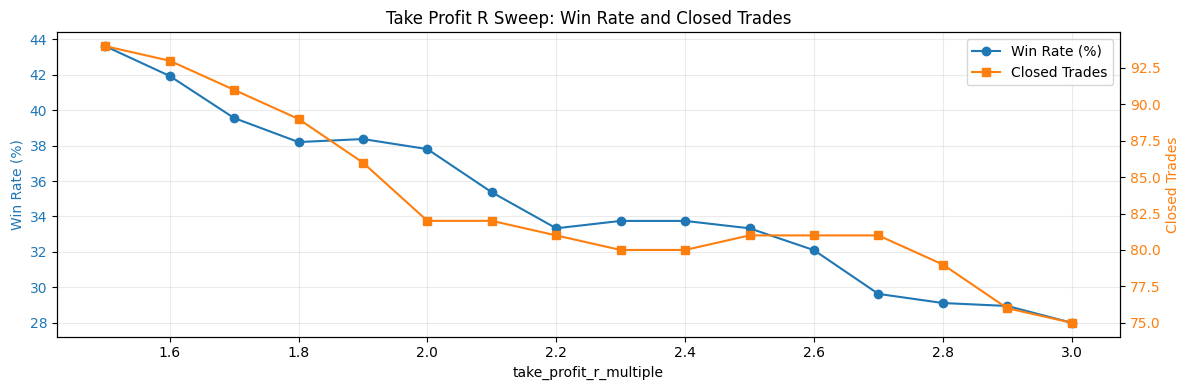

In [7]:
# TP_R_SWEEP
from copy import deepcopy

from research.src.adapters.csv_bar_repository import read_bars_from_csv
from research.src.domain.backtest_engine import run_backtest
import importlib
import research.src.infra.research_config as research_config_module

R_SWEEP_START = 1.5
R_SWEEP_END = 3.0
R_SWEEP_STEP = 0.1

def _build_r_values(start: float, end: float, step: float) -> list[float]:
    values = []
    index = 0
    current = start
    while current <= end + 1e-9:
        values.append(round(current, 2))
        index += 1
        current = start + step * index
    return values

bars_for_sweep = read_bars_from_csv(CSV_PATH)
research_config_module = importlib.reload(research_config_module)
base_config_for_sweep = research_config_module.load_bot_config(CONFIG_PATH)
r_values = _build_r_values(R_SWEEP_START, R_SWEEP_END, R_SWEEP_STEP)

tp_r_sweep_rows = []
for r_value in r_values:
    config_for_sweep = deepcopy(base_config_for_sweep)
    config_for_sweep['exit']['take_profit_r_multiple'] = r_value
    report_for_sweep = run_backtest(bars_for_sweep, config_for_sweep)
    summary_for_sweep = report_for_sweep.summary
    tp_r_sweep_rows.append({
        'r_multiple': r_value,
        'closed_trades': summary_for_sweep.closed_trades,
        'win_rate_pct': summary_for_sweep.win_rate_pct,
        'total_pnl_pct': summary_for_sweep.total_pnl_pct,
        'total_scaled_pnl_pct': summary_for_sweep.total_scaled_pnl_pct,
        'average_scaled_pnl_pct': summary_for_sweep.average_scaled_pnl_pct,
    })

print('[tp_r_sweep] range', {'start': R_SWEEP_START, 'end': R_SWEEP_END, 'step': R_SWEEP_STEP})
for row in tp_r_sweep_rows:
    print(row)

best_by_scaled = max(tp_r_sweep_rows, key=lambda row: row['total_scaled_pnl_pct'])
best_by_total = max(tp_r_sweep_rows, key=lambda row: row['total_pnl_pct'])
print('[tp_r_sweep] best_by_total_scaled_pnl_pct', best_by_scaled)
print('[tp_r_sweep] best_by_total_pnl_pct', best_by_total)

x_values = [row['r_multiple'] for row in tp_r_sweep_rows]
scaled_values = [row['total_scaled_pnl_pct'] for row in tp_r_sweep_rows]
win_rate_values = [row['win_rate_pct'] for row in tp_r_sweep_rows]
closed_trade_values = [row['closed_trades'] for row in tp_r_sweep_rows]

plt.figure(figsize=(12, 4))
plt.plot(x_values, scaled_values, marker='o', label='Total Scaled PnL (%)')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Take Profit R Sweep: Total Scaled PnL (%)')
plt.xlabel('take_profit_r_multiple')
plt.ylabel('Total Scaled PnL (%)')
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

fig, axis_left = plt.subplots(figsize=(12, 4))
axis_left.plot(x_values, win_rate_values, marker='o', color='tab:blue', label='Win Rate (%)')
axis_left.set_xlabel('take_profit_r_multiple')
axis_left.set_ylabel('Win Rate (%)', color='tab:blue')
axis_left.tick_params(axis='y', labelcolor='tab:blue')
axis_left.grid(alpha=0.25)

axis_right = axis_left.twinx()
axis_right.plot(x_values, closed_trade_values, marker='s', color='tab:orange', label='Closed Trades')
axis_right.set_ylabel('Closed Trades', color='tab:orange')
axis_right.tick_params(axis='y', labelcolor='tab:orange')

lines_left, labels_left = axis_left.get_legend_handles_labels()
lines_right, labels_right = axis_right.get_legend_handles_labels()
axis_left.legend(lines_left + lines_right, labels_left + labels_right, loc='best')
plt.title('Take Profit R Sweep: Win Rate and Closed Trades')
plt.tight_layout()
plt.show()


In [8]:
top_reasons = sorted(report_json['no_signal_reason_counts'].items(), key=lambda x: x[1], reverse=True)
trades_preview = report_json['trades'][:5]
{
    'top_no_signal_reasons': top_reasons[:10],
    'trades_preview': trades_preview,
}


{'top_no_signal_reasons': [('EMA_TREND_FILTER_FAILED', 6236),
  ('ATR_STOP_CONFLICT_MAX_LOSS', 2249),
  ('RECLAIM_NOT_FOUND', 1437),
  ('CHASE_ENTRY_TOO_FAR_FROM_EMA', 1168),
  ('RSI_TOO_HIGH', 146),
  ('PULLBACK_NOT_FOUND', 122),
  ('RSI_TOO_LOW', 3),
  ('INSUFFICIENT_BARS_1_OF_15', 1),
  ('INSUFFICIENT_BARS_2_OF_15', 1),
  ('INSUFFICIENT_BARS_3_OF_15', 1)],
 'trades_preview': [{'entry_time': '2022-01-01T22:00:00Z',
   'exit_time': '2022-01-03T16:00:00Z',
   'entry_price': 176.4615,
   'stop_price': 171.167655,
   'take_profit_price': 189.166728,
   'exit_price': 170.962254,
   'exit_reason': 'STOP_LOSS',
   'pnl_pct': -3.1164,
   'scaled_pnl_pct': -0.31164,
   'r_multiple': -1.0388,
   'position_size_multiplier': 0.1,
   'base_notional_usdc': 100.0,
   'effective_notional_usdc': 10.0,
   'holding_bars': 21},
  {'entry_time': '2022-01-04T16:00:00Z',
   'exit_time': '2022-01-04T20:00:00Z',
   'entry_price': 172.336556,
   'stop_price': 167.166459,
   'take_profit_price': 184.744788,
  

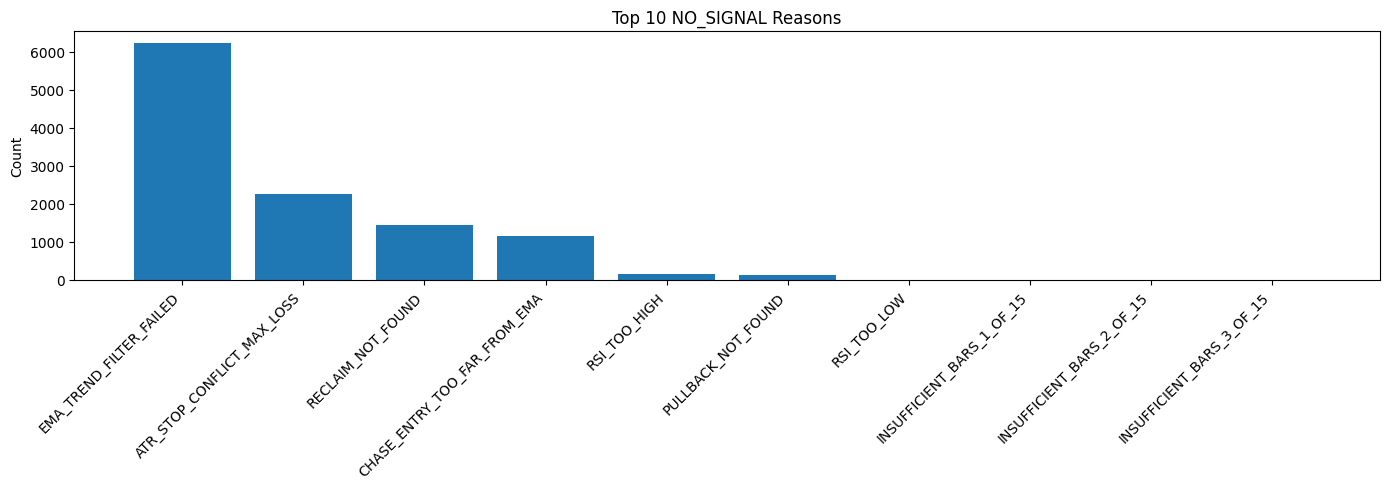

In [9]:
reason_items = sorted(report_json['no_signal_reason_counts'].items(), key=lambda x: x[1], reverse=True)[:10]

labels = [item[0] for item in reason_items]
values = [item[1] for item in reason_items]

plt.figure(figsize=(14, 5))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.title('Top 10 NO_SIGNAL Reasons')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


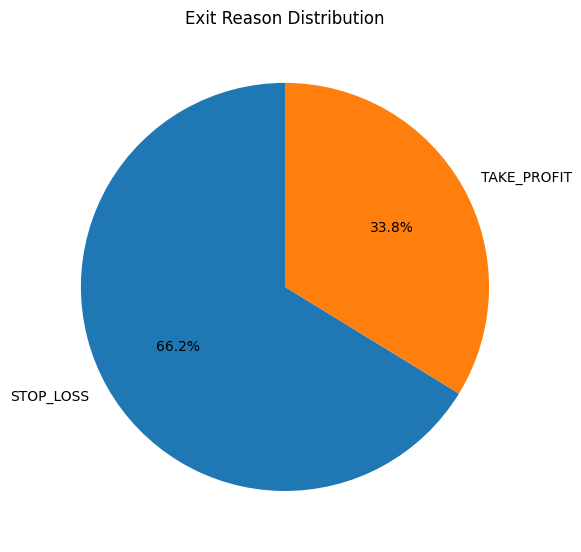

In [10]:
closed_trades = [t for t in report_json['trades'] if t.get('exit_reason') != 'OPEN']

if not closed_trades:
    print('No closed trades yet. Exit reason chart skipped.')
else:
    exit_counts = Counter(t.get('exit_reason', 'UNKNOWN') for t in closed_trades)
    labels = list(exit_counts.keys())
    values = [exit_counts[k] for k in labels]

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Exit Reason Distribution')
    plt.tight_layout()
    plt.show()


{'pnl_metric_key': 'scaled_pnl_pct', 'initial_capital_jpy': 1000000, 'final_asset_jpy': 1350037.7, 'total_return_pct': 35.0038, 'max_drawdown_pct': -11.123, 'max_drawdown_trade_index': 74}


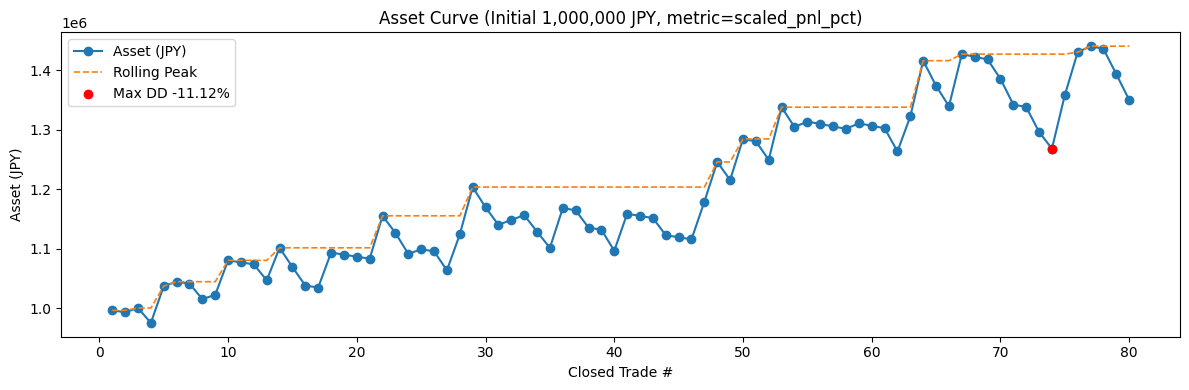

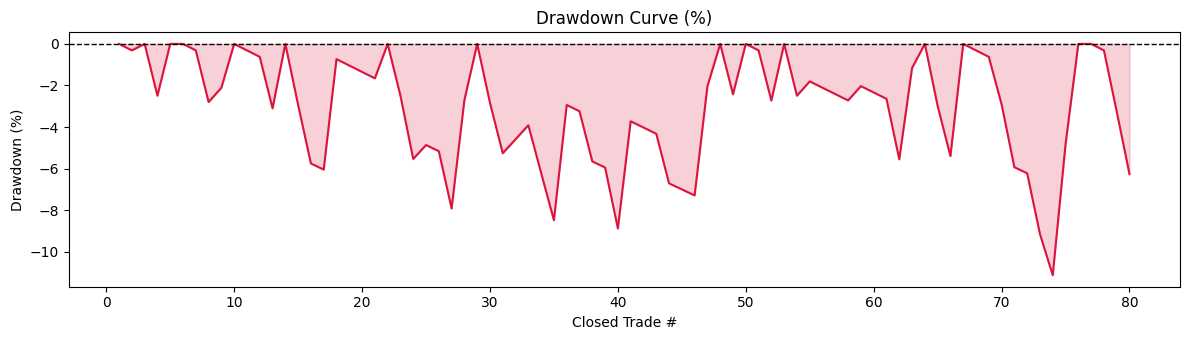

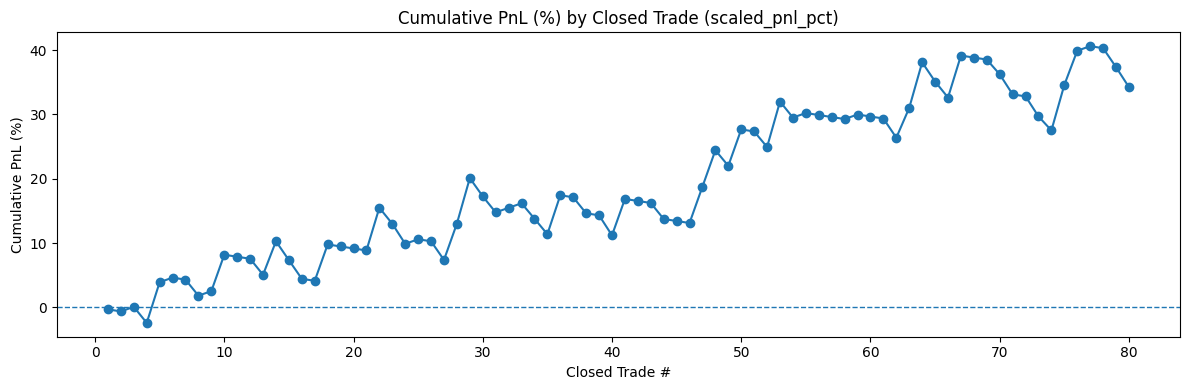

In [11]:
pnl_metric_key = 'scaled_pnl_pct' if any(t.get('scaled_pnl_pct') is not None for t in closed_trades) else 'pnl_pct'
pnl_pct_values = [t.get(pnl_metric_key) for t in closed_trades if t.get(pnl_metric_key) is not None]

if not pnl_pct_values:
    print('No closed trades yet. Equity / drawdown charts skipped.')
else:
    cumulative = []
    running = 0.0
    for value in pnl_pct_values:
        running += float(value)
        cumulative.append(running)

    equity_curve = []
    equity = float(INITIAL_CAPITAL_JPY)
    for value in pnl_pct_values:
        equity *= (1.0 + float(value) / 100.0)
        equity_curve.append(equity)

    peaks = []
    drawdowns = []
    peak = equity_curve[0]
    for value in equity_curve:
        peak = max(peak, value)
        peaks.append(peak)
        drawdowns.append((value / peak) - 1.0)

    max_drawdown = min(drawdowns)
    max_drawdown_pct = max_drawdown * 100.0
    max_dd_trade_index = drawdowns.index(max_drawdown) + 1

    final_asset = equity_curve[-1]
    total_return_pct = ((final_asset / float(INITIAL_CAPITAL_JPY)) - 1.0) * 100.0

    print({
        'pnl_metric_key': pnl_metric_key,
        'initial_capital_jpy': int(INITIAL_CAPITAL_JPY),
        'final_asset_jpy': round(final_asset, 2),
        'total_return_pct': round(total_return_pct, 4),
        'max_drawdown_pct': round(max_drawdown_pct, 4),
        'max_drawdown_trade_index': max_dd_trade_index,
    })

    x = list(range(1, len(equity_curve) + 1))

    plt.figure(figsize=(12, 4))
    plt.plot(x, equity_curve, marker='o', label='Asset (JPY)')
    plt.plot(x, peaks, linestyle='--', linewidth=1.2, label='Rolling Peak')
    plt.scatter([max_dd_trade_index], [equity_curve[max_dd_trade_index - 1]], color='red', zorder=5, label=f'Max DD {max_drawdown_pct:.2f}%')
    plt.title(f'Asset Curve (Initial {INITIAL_CAPITAL_JPY:,} JPY, metric={pnl_metric_key})')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Asset (JPY)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3.5))
    drawdown_pct_series = [value * 100.0 for value in drawdowns]
    plt.plot(x, drawdown_pct_series, color='crimson')
    plt.fill_between(x, drawdown_pct_series, 0, color='crimson', alpha=0.2)
    plt.axhline(0, linestyle='--', linewidth=1, color='black')
    plt.title('Drawdown Curve (%)')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Drawdown (%)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o')
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.title(f'Cumulative PnL (%) by Closed Trade ({pnl_metric_key})')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Cumulative PnL (%)')
    plt.tight_layout()
    plt.show()



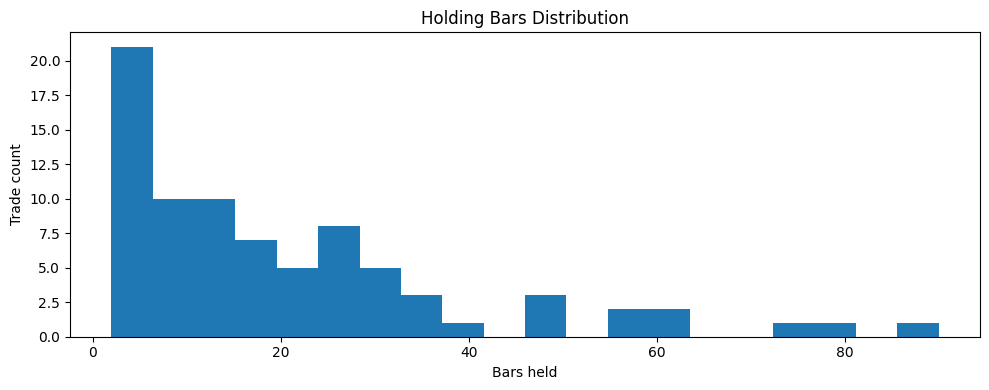

In [12]:
holding_bars = [t.get('holding_bars') for t in closed_trades if t.get('holding_bars') is not None]

if not holding_bars:
    print('No closed trades yet. Holding bars histogram skipped.')
else:
    unique_count = len(set(holding_bars))
    bins = min(max(unique_count, 5), 20)

    plt.figure(figsize=(10, 4))
    plt.hist(holding_bars, bins=bins)
    plt.title('Holding Bars Distribution')
    plt.xlabel('Bars held')
    plt.ylabel('Trade count')
    plt.tight_layout()
    plt.show()


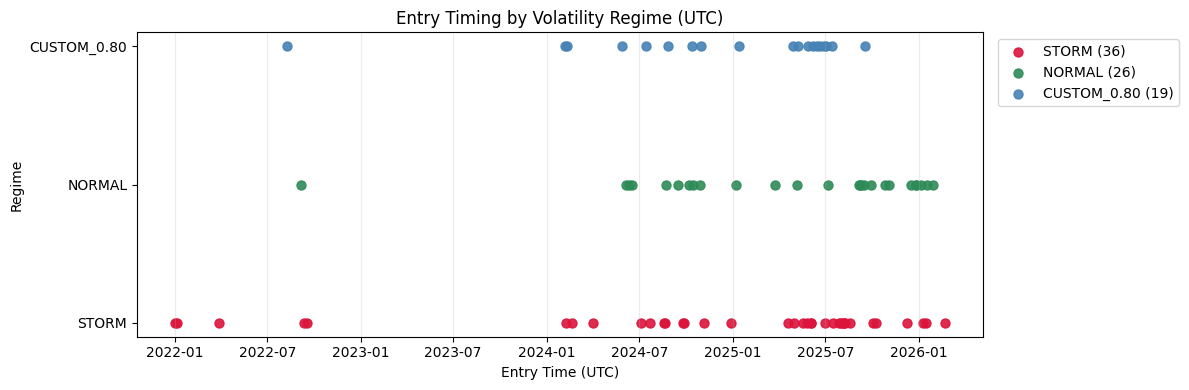

{'regime_counts': {'STORM': 36, 'CUSTOM_0.80': 19, 'NORMAL': 26}}


In [13]:
from datetime import datetime

entry_trades = sorted(
    [trade for trade in report_json['trades'] if trade.get('entry_time')],
    key=lambda trade: trade['entry_time'],
)

if not entry_trades:
    print('No entry trades yet. Regime timing chart skipped.')
else:
    def regime_from_multiplier(multiplier):
        if multiplier is None:
            return 'UNKNOWN'
        value = round(float(multiplier), 2)
        if value <= 0.50:
            return 'STORM'
        if value <= 0.75:
            return 'VOLATILE'
        if value == 1.00:
            return 'NORMAL'
        return f'CUSTOM_{value:.2f}'

    regime_colors = {
        'STORM': 'crimson',
        'VOLATILE': 'darkorange',
        'NORMAL': 'seagreen',
        'UNKNOWN': 'gray',
    }

    regime_to_times = {}
    for trade in entry_trades:
        regime = regime_from_multiplier(trade.get('position_size_multiplier'))
        entry_time = datetime.fromisoformat(trade['entry_time'].replace('Z', '+00:00'))
        regime_to_times.setdefault(regime, []).append(entry_time)

    ordered_regimes = [r for r in ['STORM', 'VOLATILE', 'NORMAL', 'UNKNOWN'] if r in regime_to_times]
    custom_regimes = sorted([r for r in regime_to_times if r not in {'STORM', 'VOLATILE', 'NORMAL', 'UNKNOWN'}])
    ordered_regimes.extend(custom_regimes)

    y_map = {regime: index for index, regime in enumerate(ordered_regimes)}

    plt.figure(figsize=(12, 4))
    for regime in ordered_regimes:
        times = regime_to_times.get(regime, [])
        if not times:
            continue
        y_values = [y_map[regime]] * len(times)
        color = regime_colors.get(regime, 'steelblue')
        plt.scatter(
            times,
            y_values,
            s=42,
            alpha=0.9,
            color=color,
            label=f"{regime} ({len(times)})",
        )

    plt.yticks([y_map[regime] for regime in ordered_regimes], ordered_regimes)
    plt.title('Entry Timing by Volatility Regime (UTC)')
    plt.xlabel('Entry Time (UTC)')
    plt.ylabel('Regime')
    plt.grid(axis='x', alpha=0.25)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout()
    plt.show()

    regime_counts = {regime: len(times) for regime, times in regime_to_times.items()}
    print({'regime_counts': regime_counts})

